11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


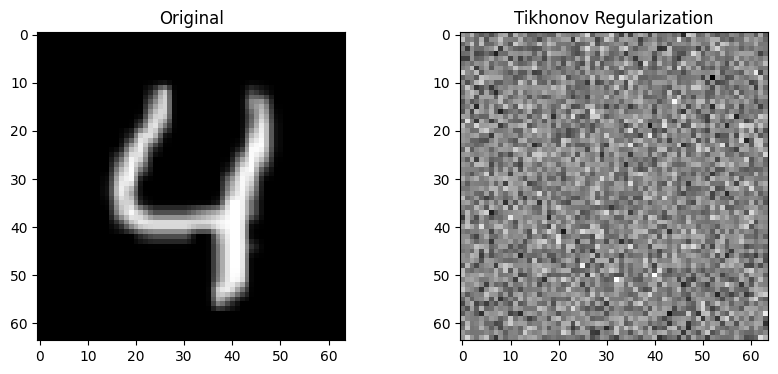

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import radon
from numpy.linalg import inv

# بارگذاری مجموعه داده MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# تبدیل داده‌ها به نوع float32 و نرمال‌سازی مقادیر به بازه [۰, ۱]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# فیلتر کردن تصاویر عدد ۴ در داده‌های آموزشی و تست
x_train_4 = x_train[y_train == 4]
x_test_4 = x_test[y_test == 4]

# تغییر اندازه تصاویر به 64×64 پیکسل
x_train_4 = tf.image.resize(x_train_4[..., np.newaxis], [64, 64]).numpy()
x_test_4 = tf.image.resize(x_test_4[..., np.newaxis], [64, 64]).numpy()

# اعمال تبدیل رادن به تصاویر
theta = np.linspace(0., 180., max(x_train_4.shape[1:3]), endpoint=False)
x_train_radon_4 = np.array([radon(x_train_4[i].reshape(64, 64), theta=theta) for i in range(x_train_4.shape[0])])
x_test_radon_4 = np.array([radon(x_test_4[i].reshape(64, 64), theta=theta) for i in range(x_test_4.shape[0])])

# تبدیل تصاویر به بردارهای تخت شده
x_train_radon_flat_4 = x_train_radon_4.reshape(x_train_radon_4.shape[0], -1)
x_test_radon_flat_4 = x_test_radon_4.reshape(x_test_radon_4.shape[0], -1)

# تعریف ماتریس A
A = np.random.randn(x_train_radon_flat_4.shape[1], x_train_radon_flat_4.shape[1])

# ایجاد y برای داده‌های آموزشی و تست
y_train = A @ x_train_radon_flat_4.T
y_test = A @ x_test_radon_flat_4.T

# کاهش مقدار نویز
def add_noise(y, noise_factor=0.01):
    y_noisy = y + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=y.shape)
    return np.clip(y_noisy, 0.0, 1.0)

# افزودن نویز به داده‌های آموزشی و تست
y_train_noisy = add_noise(y_train)
y_test_noisy = add_noise(y_test)

# چرخاندن y_train_noisy و y_test_noisy به ماتریس‌های اصلی
y_train_noisy = y_train_noisy.T
y_test_noisy = y_test_noisy.T

# تعریف تابع برای محاسبه x با استفاده از تیخونوف رگولارزیشن
def tikhonov_regularization(A, y, alpha):
    I = np.eye(A.shape[1])
    x_estimate = inv(A.T @ A + alpha * I) @ A.T @ y
    return x_estimate

# مقدار آلفا برای تیخونوف رگولارزیشن
alpha = 0.1

# انتخاب یک تصویر از داده‌های تست برای اعمال روش
y_noisy_test = y_test_noisy[0]

# بازسازی x_test با استفاده از داده‌های تست
x_test_estimated = tikhonov_regularization(A, y_noisy_test, alpha)

# نمایش نتایج
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(x_test_4[0].reshape(64, 64), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Tikhonov Regularization")
plt.imshow(x_test_estimated.reshape(64, 64), cmap='gray')

plt.show()